**Netflix Movies Recommendation System using Keras and Tensorflow**

Import all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Downloading Netflix dataset from kaggle

In [2]:
!pip install Kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-04-30 20:52:11           4079  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2347  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            521  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            241  
dhruvildave/wikibooks-dataset             

In [3]:
!kaggle datasets download -d netflix-inc/netflix-prize-data

 99% 673M/683M [00:09<00:00, 41.0MB/s]
100% 683M/683M [00:09<00:00, 72.3MB/s]


In [4]:
!unzip /content/netflix-prize-data.zip -d /content/netflix-prize-data

Archive:  /content/netflix-prize-data.zip
  inflating: /content/netflix-prize-data/README  
  inflating: /content/netflix-prize-data/combined_data_1.txt  
  inflating: /content/netflix-prize-data/combined_data_2.txt  
  inflating: /content/netflix-prize-data/combined_data_3.txt  
  inflating: /content/netflix-prize-data/combined_data_4.txt  
  inflating: /content/netflix-prize-data/movie_titles.csv  
  inflating: /content/netflix-prize-data/probe.txt  
  inflating: /content/netflix-prize-data/qualifying.txt  


Data Preparation

In [5]:
with open('/content/netflix-prize-data/Netflix_movie_ratings.csv', mode='w') as data:
    row = list()
    files = ['/content/netflix-prize-data/combined_data_1.txt', 
             '/content/netflix-prize-data/combined_data_2.txt',
             '/content/netflix-prize-data/combined_data_3.txt', 
             '/content/netflix-prize-data/combined_data_4.txt']
    
    for file in files:
        print('reading ratings from {}...'.format(file))
        with open(file) as f:
            for line in f:
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    #all are rating
                    movid_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movid_id)
                    data.write(','.join(row))
                    data.write('\n')

reading ratings from /content/netflix-prize-data/combined_data_1.txt...
reading ratings from /content/netflix-prize-data/combined_data_2.txt...
reading ratings from /content/netflix-prize-data/combined_data_3.txt...
reading ratings from /content/netflix-prize-data/combined_data_4.txt...


Loading Data

In [2]:
# Ratings data.
ratings_df = pd.read_csv('/content/netflix-prize-data/Netflix_movie_ratings.csv', names=['movie_id', 'user_id','rating','date'])
#Feature Selection
ratings = ratings_df[['movie_id', 'user_id','rating']]
#Changing datatype to reduce memory consumption
ratings = ratings.astype({"movie_id":'int16', 'user_id':'int32', "rating": 'int8'})

# Movies data
movies_df = pd.read_csv('/content/netflix-prize-data/movie_titles.csv', encoding = 'ISO-8859-1', names=['movie_id', 'year_of_release','movie_title'])

In [7]:
ratings.head()

,movie_id,user_id,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [8]:
movies_df.head()

,movie_id,year_of_release,movie_title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


Size of Netflix Data

In [9]:
ratings.shape

(100480507, 3)

In [10]:
movies_df.shape

(17770, 3)

Type of the features

In [11]:
ratings.columns

Index(['movie_id', 'user_id', 'rating'], dtype='object')

In [12]:
ratings.values

array([[      1, 1488844,       3],
       [      1,  822109,       5],
       [      1,  885013,       4],
       ...,
       [  17770,  234275,       1],
       [  17770,  255278,       4],
       [  17770,  453585,       2]], dtype=int32)

Target Class

In [13]:
ratings['rating'].unique()

array([3, 5, 4, 2, 1], dtype=int8)

In [14]:
ratings['rating'].describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Data Cleaning

In [15]:
# Checking Missing Values
print(ratings.isnull().any())

movie_id    False
user_id     False
rating      False
dtype: bool


In [16]:
#Checking if dataset has duplicates
ratings[ratings.duplicated()]

,movie_id,user_id,rating


Data Visualization

Rating Distribution

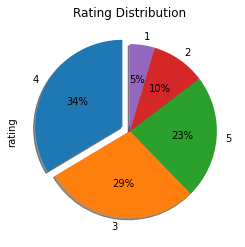

In [17]:
plt.figure(figsize=(6,4))
ratings["rating"].value_counts().plot.pie(explode = (0.1,0,0,0,0), title='Rating Distribution', autopct = '%1.0f%%', shadow=True, startangle=90)

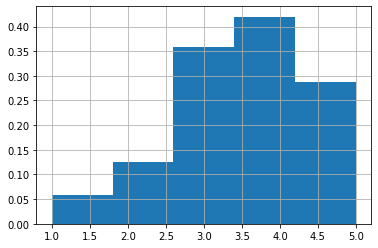

In [18]:
plt.figure(figsize=(6,4))
ratings['rating'].hist( bins=5, histtype='stepfilled', density=True)

Total movies released per year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93]),
 <a list of 94 Text major ticklabel objects>)

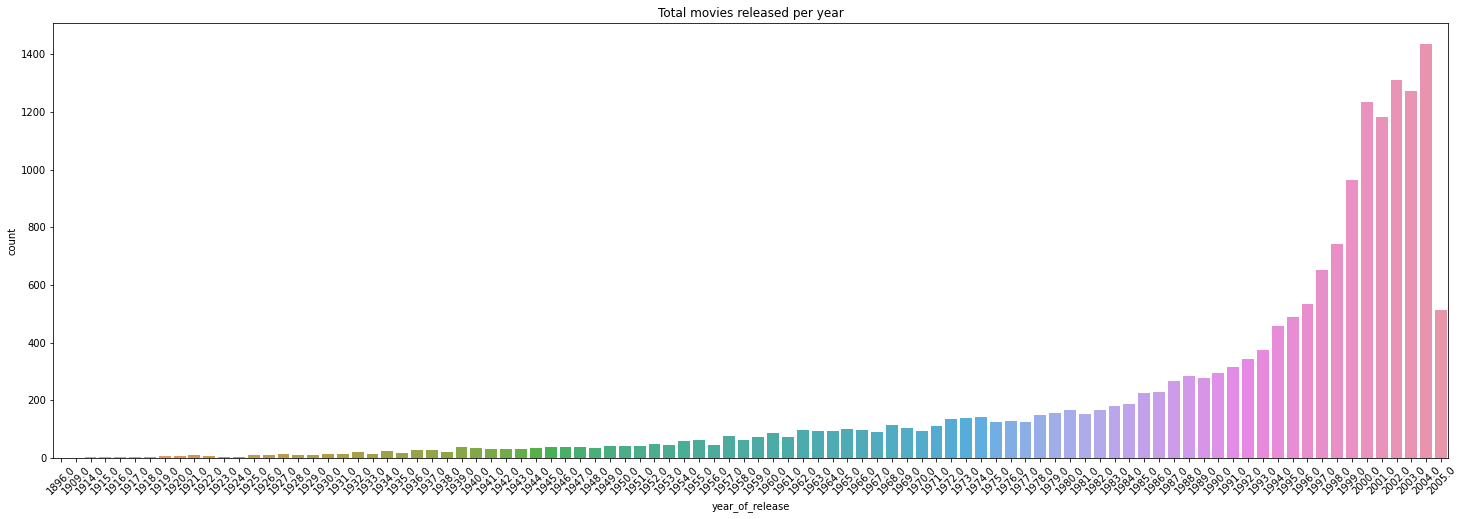

In [19]:
plt.figure(figsize=(25,8))
sns.countplot(movies_df.year_of_release)
plt.title('Total movies released per year')
plt.xticks(rotation=45)

Total ratings per year

(array([1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.]),
 <a list of 9 Text major ticklabel objects>)

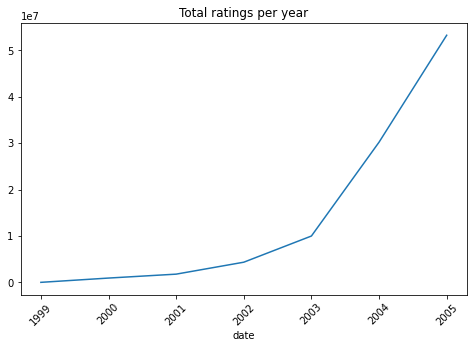

In [6]:
plt.figure(figsize=(8,5))
ratings_df['date'] =  pd.to_datetime(ratings_df['date'], format='%Y-%m-%d')
ratings_df.groupby(ratings_df.date.dt.year)['rating'].count().plot()
plt.title('Total ratings per year')
plt.xticks(rotation=45)

Top 10 Movies with most ratings

<Figure size 1440x576 with 0 Axes>

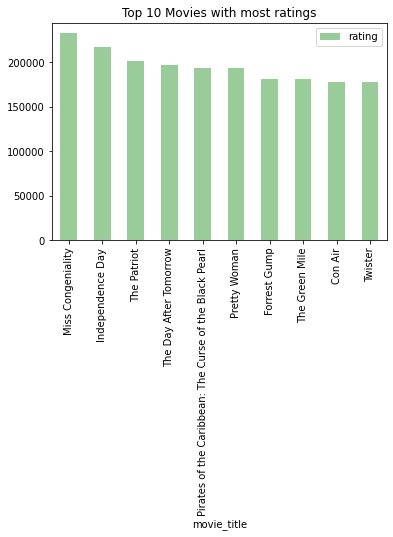

In [5]:
plt.figure(figsize=(20,8))
movie_ratings = ratings.groupby('movie_id')['rating'].count()
top_movies = movie_ratings.sort_values(ascending=False)[:10]
top_movies = pd.merge(top_movies, movies_df, how='inner', on='movie_id')
top_movies[['movie_title','rating']].set_index('movie_title').plot(kind='bar', alpha=0.4, color=['green'], title='Top 10 Movies with most ratings')

Total ratings per year for top 10 Movies

Text(0.5, 1.0, 'Total ratings per year for top 10 Movies')

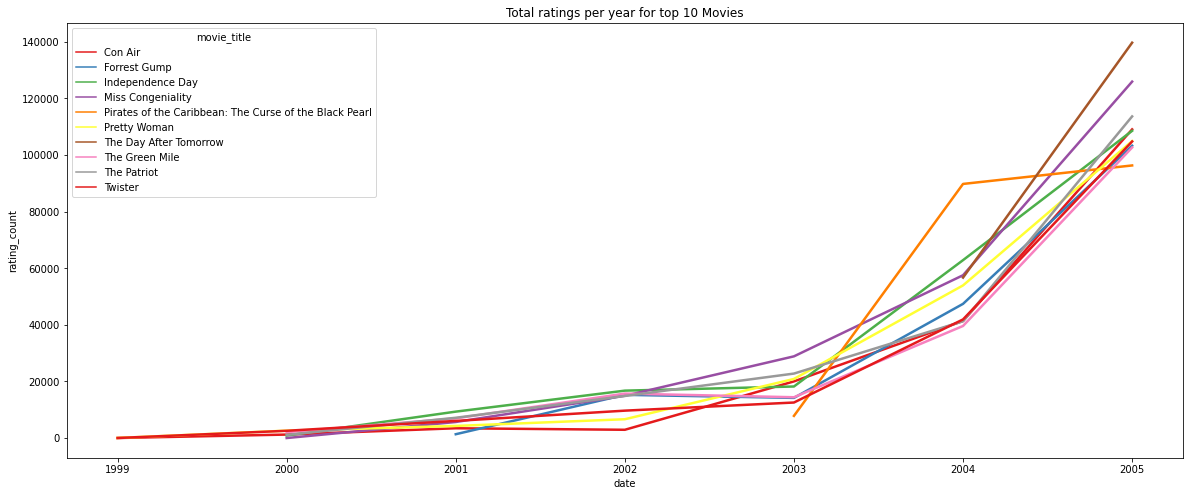

In [7]:
plt.figure(figsize=(20,8))
top_10_movies = top_movies['movie_id'].unique()
ratings_data = ratings_df[ratings_df['movie_id'].isin(top_10_movies)]
ratings_data = pd.merge(ratings_data, movies_df, how='inner', on='movie_id')
movie_ratings = ratings_data.groupby([ratings_data['movie_title'],ratings_data.date.dt.year]).agg(rating_count=('rating', 'count'))
sns.lineplot(data=movie_ratings, x="date", y="rating_count", hue="movie_title", palette='Set1', linewidth=2.5)
plt.title('Total ratings per year for top 10 Movies')

Min, Max, Median, Mean ratings for Top 10 Movies

Text(0.5, 1.0, 'Min, Max, Median, Mean ratings for Top 10 Movies')

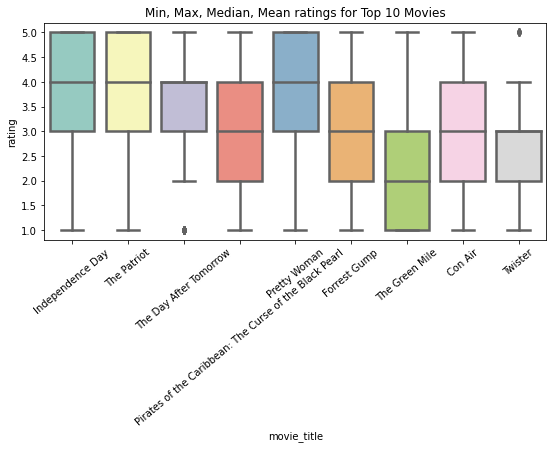

In [23]:
plt.figure(figsize=(9,4))
sns.color_palette("Set2")
top_movies_ratings = ratings.join(top_movies, rsuffix='_r', how='inner', on='movie_id')
sns.boxplot(x="movie_title", y="rating", data = top_movies_ratings, palette="Set3", linewidth=2.5)
plt.xticks(rotation=40)
plt.title('Min, Max, Median, Mean ratings for Top 10 Movies')

5-Star rated Top 10 Movies

<Figure size 1440x576 with 0 Axes>

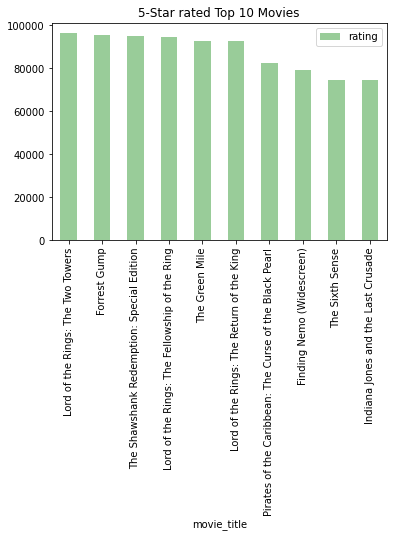

In [8]:
plt.figure(figsize=(20,8))
five_star_ratings = ratings[ratings['rating']==5]
movie_ratings = five_star_ratings.groupby('movie_id')['rating'].count()
top_movies = movie_ratings.sort_values(ascending=False)[:10]
top_movies = pd.merge(top_movies, movies_df, how='inner', on='movie_id')
top_movies[['movie_title','rating']].set_index('movie_title').plot(kind='bar',  alpha=0.4, color=['green'], title='5-Star rated Top 10 Movies')

Total ratings per year for top 10 5-star rated Movies

Text(0.5, 1.0, 'Total ratings per year for top 10 5-star rated Movies')

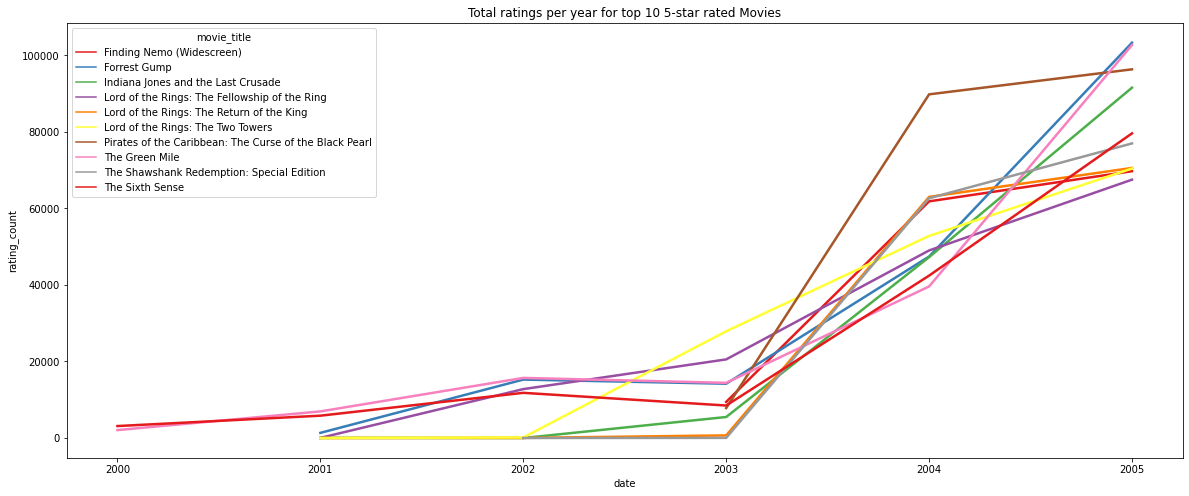

In [9]:
plt.figure(figsize=(20,8))
top_10_movies = top_movies['movie_id'].unique()
ratings_data = ratings_df[ratings_df['movie_id'].isin(top_10_movies)]
ratings_data = pd.merge(ratings_data, movies_df, how='inner', on='movie_id')
movie_ratings = ratings_data.groupby([ratings_data['movie_title'],ratings_data.date.dt.year]).agg(rating_count=('rating', 'count'))
sns.lineplot(data=movie_ratings, x="date", y="rating_count", hue="movie_title", palette='Set1', linewidth=2.5)
plt.title('Total ratings per year for top 10 5-star rated Movies')

Min, Max, Median, Mean ratings for 5-Star rated Top 10 Movies

Text(0.5, 1.0, 'Min, Max, Median, Mean ratings for 5-Star rated Top 10 Movies')

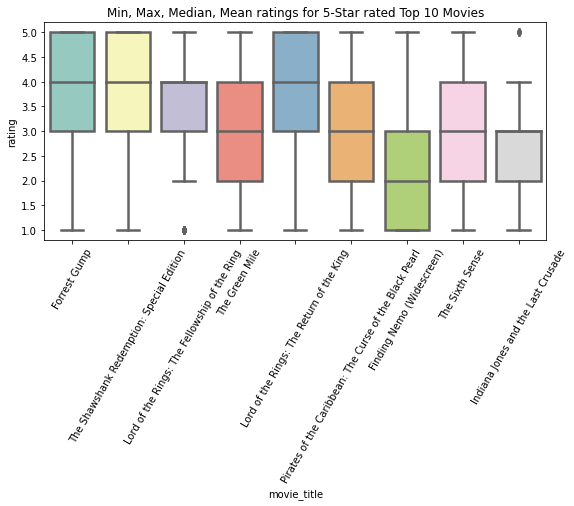

In [10]:
plt.figure(figsize=(9,4))
top_movies_ratings = ratings.join(top_movies, rsuffix='_r', how='inner', on='movie_id')
sns.boxplot(x="movie_title", y="rating", data = top_movies_ratings, palette="Set3", linewidth=2.5)
plt.xticks(rotation=60)
plt.title('Min, Max, Median, Mean ratings for 5-Star rated Top 10 Movies')

Top 10 Users with most ratings

<Figure size 720x432 with 0 Axes>

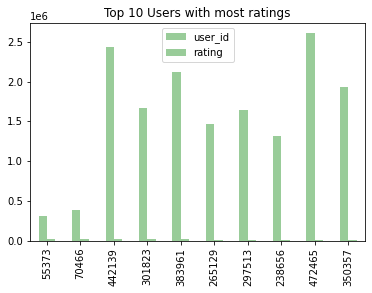

In [11]:
plt.figure(figsize=(10,6))
user_ratings = ratings.groupby('user_id',as_index=False)['rating'].count()
top_users = user_ratings.sort_values(by='rating',ascending=False)[:10]
top_users.plot(kind='bar', alpha=0.4, color=['green'], title='Top 10 Users with most ratings')

Total ratings per year for top 10 Netflix users

Text(0.5, 1.0, 'Total ratings per year for top 10 Netflix users')

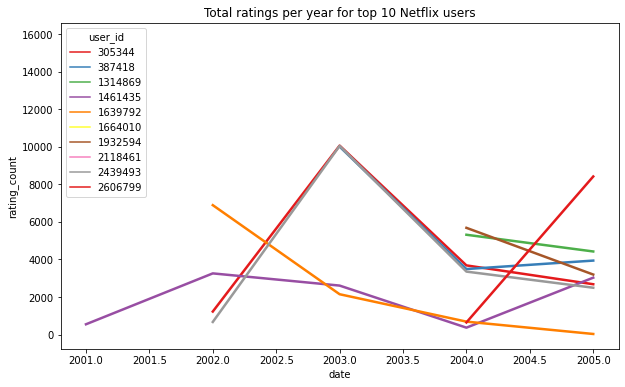

In [12]:
plt.figure(figsize=(10,6))
top_10_users = top_users['user_id'].unique()
ratings_data = ratings_df[ratings_df['user_id'].isin(top_10_users)]
user_ratings = ratings_data.groupby([ratings_data['user_id'],ratings_data.date.dt.year]).agg(rating_count=('rating', 'count'))
sns.lineplot(data=user_ratings, x="date", y="rating_count", hue="user_id", palette='Set1', linewidth=2.5)
plt.title('Total ratings per year for top 10 Netflix users')

Data Preprocessing

*   Encoding Users and Movies as integer indices



In [13]:
movie_ratings = ratings.groupby('movie_id',as_index=False).agg(rating_count = ('rating','count'))
top_movies = movie_ratings.sort_values(by='rating_count',ascending=False)[:5000]
top_movies = top_movies['movie_id'].unique()

user_ratings = ratings.groupby('user_id',as_index=False).agg(rating_count = ('rating','count'))
top_users = user_ratings.sort_values(by='rating_count', ascending=False)[:100000]
top_users = top_users['user_id'].unique()

ratings = ratings[ratings['movie_id'].isin(top_movies) & ratings['user_id'].isin(top_users)]

In [14]:
user_ids = ratings["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings["movie_id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings["user"] = ratings["user_id"].map(user2user_encoded)
ratings["movie"] = ratings["movie_id"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
ratings["rating"] = ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings["rating"])
max_rating = max(ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 100000, Number of Movies: 5000, Min rating: 1.0, Max rating: 5.0


Data Normalization

*   Using Min-Max Normalization



In [15]:
from sklearn.preprocessing import MinMaxScaler
x = ratings[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = MinMaxScaler().fit_transform(np.array(ratings['rating']).reshape(-1,1))
#y = ratings["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

Splitting data for training and validation

In [16]:
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)


Recommender Systems using keras

In [17]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)




Creating & Compiling Model

In [18]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=1e-5), metrics= [tf.keras.metrics.RootMeanSquaredError()]
)

Training the model

In [21]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=10000,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
5445/5445 [==============================] - 164s 29ms/step - loss: 0.0855 - root_mean_squared_error: 0.2919 - val_loss: 0.0941 - val_root_mean_squared_error: 0.3064
Epoch 2/5
5445/5445 [==============================] - 157s 29ms/step - loss: 0.0690 - root_mean_squared_error: 0.2623 - val_loss: 0.0906 - val_root_mean_squared_error: 0.3007
Epoch 3/5
5445/5445 [==============================] - 157s 29ms/step - loss: 0.0677 - root_mean_squared_error: 0.2599 - val_loss: 0.0902 - val_root_mean_squared_error: 0.3000
Epoch 4/5
5445/5445 [==============================] - 155s 29ms/step - loss: 0.0666 - root_mean_squared_error: 0.2578 - val_loss: 0.0900 - val_root_mean_squared_error: 0.2998
Epoch 5/5
5445/5445 [==============================] - 155s 29ms/step - loss: 0.0657 - root_mean_squared_error: 0.2559 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2994


In [22]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  5000000   
_________________________________________________________________
embedding_1 (Embedding)      multiple                  100000    
_________________________________________________________________
embedding_2 (Embedding)      multiple                  250000    
_________________________________________________________________
embedding_3 (Embedding)      multiple                  5000      
Total params: 5,355,000
Trainable params: 5,355,000
Non-trainable params: 0
_________________________________________________________________


Ploting loss and evaluation metric

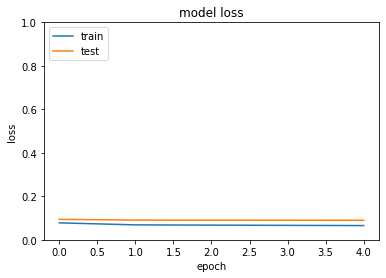

In [26]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.ylim(0, 1)
plt.show()

Recommends Movies by predicting ratings of the movies that user likely to give and returns top 10 movie recommendations with high predicted ratings


In [27]:
def recommend_user(userId):
  # Let us get a user and see the top recommendations.
  #userId = ratings.user_id.sample(1).iloc[0]

  movies_watched_by_user = ratings[ratings.user_id == userId]
  movies_not_watched = movies_df[~movies_df["movie_id"].isin(movies_watched_by_user.movie_id.values)]["movie_id"]
  movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
  movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
  user_encoder = user2user_encoded.get(userId)
  user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
  predicted_ratings = model.predict(user_movie_array).flatten()
  top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
  recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

  print("Showing recommendations for user: {}".format(userId))
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)
  top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movie_id.values
  )
  movie_df_rows = movies_df[movies_df["movie_id"].isin(top_movies_user)]
  for row in movie_df_rows.itertuples():
      print(row.movie_title)

  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  recommended_movies = movies_df[movies_df["movie_id"].isin(recommended_movie_ids)]
  for row in recommended_movies.itertuples():
      print(row.movie_title)
  return

In [28]:
for user in top_10_users:
  recommend_user(user)

Showing recommendations for user: 305344
Movies with high ratings from user
--------------------------------
Star Wars: Episode V: The Empire Strikes Back
The Manchurian Candidate
The French Connection II
Manhunter
Coal Miner's Daughter: Collector's Edition
--------------------------------
Top 10 movie recommendations
--------------------------------
Ray
Doctor Zhivago
The Hunt for Red October
Citizen Kane
The Grapes of Wrath
Hotel Rwanda
Million Dollar Baby
Mystic River
Crash
The Notebook
Showing recommendations for user: 387418
Movies with high ratings from user
--------------------------------
The Man Without a Face
Rush Hour
Eddie Izzard: Circle
Kingdom of Heaven
Legally Blonde
--------------------------------
Top 10 movie recommendations
--------------------------------
Six Feet Under: Season 4
Nip/Tuck: Season 2
South Park: Ghouls
Curb Your Enthusiasm: Season 4
South Park: Insults to Injuries
Kung Fu Hustle
Pirates of the Caribbean: The Curse of the Black Pearl: Bonus Material
Fi

Save the model

In [30]:
model.save('saved_models/netflix_recommender_system')

INFO:tensorflow:Assets written to: saved_models/netflix_recommender_system/assets
